# Fine-Tuning of OpenAI detector

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab Notebooks/ai_text_detection/cookbooks

/content/drive/MyDrive/Colab Notebooks/ai_text_detection/cookbooks


In [1]:
import json
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
# import tqdm
from sklearn.utils import resample
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
import sys
import os
sys.path.append("/mnt/data/bobae/ai_text_detection")

from utils.cuda_helper import *

### Set GPU

In [3]:
print_gpu_usage()

Current GPU memory usage: 0.00 MB
Maximum GPU memory usage: 0.00 MB


In [4]:
print_gpu_devie_name()

cuda 0: NVIDIA GeForce RTX 2080 Ti
cuda 1: NVIDIA GeForce RTX 2080 Ti


In [5]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
num_gpus = torch.cuda.device_count()

if num_gpus>1:
    device = "cuda:0"

In [6]:
device

'cuda:0'

In [7]:
# Get the device properties for the current GPU
device_props = torch.cuda.get_device_properties(torch.cuda.current_device())
print(device_props)

# Print the total GPU memory in gigabytes
total_gpu_memory = device_props.total_memory / (1024**3)
print(f"Total GPU memory: {total_gpu_memory:.2f} GB")

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Total GPU memory: 10.75 GB


### Load json data file and convert to dataframe

In [8]:
# human data

# loads a tofel dataset
with open('../dataset/human/tofel.json', "r") as f:
    h_tofel_dataset = json.load(f)

# loads an arxiv dataset
with open('../dataset/human/arxiv.json', "r") as f:
    h_arxiv_dataset = json.load(f)

# loads student essay
with open('../dataset/human/student_essay.json', "r") as f:
    h_essay_dataset = json.load(f)

# loads student computer essay
with open('../dataset/human/student_cs_essay.json', "r") as f:
    h_essay_cs_dataset = json.load(f)

In [9]:
# gpt data

# loads a tofel dataset
with open('../dataset/ai/gpt2medium_tofel.json', "r") as f:
    gpt_tofel_dataset = json.load(f)

# loads an arxiv dataset
with open('../dataset/ai/gpt2medium_arxiv.json', "r") as f:
    gpt_arxiv_dataset = json.load(f)

# loads student essay
with open('../dataset/ai/gpt2medium_essay.json', "r") as f:
    gpt_essay_dataset = json.load(f)

# loads student computer essay
with open('../dataset/ai/gpt2medium_essay_cs.json', "r") as f:
    gpt_essay_cs_dataset = json.load(f)

# loads a tofel dataset
with open('../dataset/ai/gpt35_tofel.json', "r") as f:
    gpt_35_tofel_dataset = json.load(f)

# loads student computer essay
with open('../dataset/ai/gpt35_essay_cs.json', "r") as f:
    gpt_35_essay_cs_dataset = json.load(f)

In [10]:
h_dataset = []
for i in [h_tofel_dataset, h_arxiv_dataset, h_essay_dataset, h_essay_cs_dataset]:
    h_dataset.extend(i)

len(h_dataset)

2478

In [11]:
gpt_dataset = []
for i in [gpt_tofel_dataset, gpt_arxiv_dataset, gpt_essay_dataset, gpt_essay_cs_dataset,
          gpt_35_tofel_dataset, gpt_35_essay_cs_dataset]:
    gpt_dataset.extend(i)

len(gpt_dataset)

2956

In [12]:
dct = {
    "text": [item['input'] for item in h_dataset] + [item['input'] for item in gpt_dataset],
    "label": [item['label'] for item in h_dataset] + [item['label'] for item in gpt_dataset],
}

df = pd.DataFrame(dct)

def label_to_numeric(value):
    if value == "human":
        return 0
    else:
        return 1

df['target'] = df['label'].apply(lambda x: label_to_numeric(x))

In [13]:
class_counts = df['target'].value_counts()
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Separate majority and minority classes
majority_df = df[df['target'] == majority_class]
minority_df = df[df['target'] == minority_class]

# Undersample majority class
undersampled_majority_df = resample(majority_df,
                                    replace=False,  # Sample without replacement
                                    n_samples=len(minority_df),  # Match minority class size
                                    random_state=42)  # For reproducibility

# Combine minority class with undersampled majority class
undersampled_df = pd.concat([undersampled_majority_df, minority_df])
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
df = undersampled_df
df

,text,label,target
0,The spectral action on noncommutative torus is...,human,1
1,Computerized Ordering System Thesis\n\nIntrodu...,ai,0
2,We report observation of spin-orbit Berry's ph...,human,1
3,We report observation of spin-orbit Berry's ph...,ai,0
4,\n\nThe first thing you need to do is to get y...,ai,0
...,...,...,...
4951,The Lessons from Yusufiyah Essay\n\nThe Lesson...,human,1
4952,We present an algorithm that produces the clas...,ai,0
4953,In this paper we investigate the optimal contr...,human,1
4954,Correlation between Socioeconomic Status and H...,human,1


### Preparing the Dataset and Dataloader

In [14]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = self.data.text
        self.target = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            pad_to_max_length=True,
            max_length=self.max_len,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.target[index], dtype=torch.float)
        }

In [15]:
tokenizer = AutoTokenizer.from_pretrained("TrustSafeAI/RADAR-Vicuna-7B")
model = AutoModelForSequenceClassification.from_pretrained("TrustSafeAI/RADAR-Vicuna-7B")

/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [16]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [17]:
train_size = 0.8
train_data=df.sample(frac=train_size, random_state=42)
test_data=df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (4956, 3)
TRAIN Dataset: (3965, 3)
TEST Dataset: (991, 3)


In [18]:
train_params = {'batch_size': TRAIN_BATCH_SIZE, 'shuffle': True, 'num_workers': 0}
test_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': True, 'num_workers': 0}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

### Fine Tuning Functions

In [19]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [20]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [54]:
# Training Loop with Early Stopping:**
def train_model(epochs, file_name, model):
  best_loss = float('inf')
  best_model_weights = None
  patience = 10

  train_losses = []
  valid_losses = []

  model = model.to(device)
  for epoch in range(1, epochs+1):
    n_correct = 0
    tr_loss = 0
    nb_tr_steps = 0; nb_tr_examples = 0;

    ###################
    # train the model #
    ###################
    model.train()
    for i, data in enumerate(tqdm(training_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss_ = loss_function(outputs.logits, targets)

        tr_loss += loss_.item()
        big_val, big_idx = torch.max(outputs.logits, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if i%100==0:
            step_loss = tr_loss/nb_tr_steps
            step_acc = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 100 steps: {step_loss}")
            print(f"Training Accuracy per 100 steps: {step_acc}")
            print("=="*50)

        optimizer.zero_grad()
        loss_.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    train_epoch_loss = tr_loss/nb_tr_steps
    train_epoch_acc = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {train_epoch_loss}")
    print(f"Training Accuracy Epoch: {train_epoch_acc}")
    train_losses.append(train_epoch_loss)

    # ######################
    # # validate the model #
    # ######################
    # model.eval()  # Set model to evaluation mode
    # val_n_correct = 0; val_n_wrong = 0; total = 0;
    # val_loss = 0;
    # nb_val_steps = 0; nb_val_example = 0;
    # with torch.no_grad():  # Disable gradient calculation for validation
    #     for i, data in enumerate(tqdm(testing_loader)):
    #       ids = data['ids'].to(device, dtype = torch.long)
    #       mask = data['mask'].to(device, dtype = torch.long)
    #       token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
    #       targets = data['target'].to(device, dtype = torch.long)

    #       outputs = model(ids, mask, token_type_ids)
    #       loss_ = loss_function(outputs.logits, targets)

    #       val_loss += loss_.item()
    #       big_val, big_idx = torch.max(outputs.logits, dim=1)
    #       val_n_correct += calcuate_accuracy(big_idx, targets)

    #       nb_val_steps += 1
    #       nb_val_examples += targets.size(0)

    #       if i%100==0:
    #         step_loss = tr_loss/nb_tr_steps
    #         step_acc = (n_correct*100)/nb_tr_examples
    #         print(f"Validation Loss per 100 steps: {step_loss}")
    #         print(f"Validation Accuracy per 100 steps: {step_acc}")

    #       if val_loss < best_loss:
    #         best_loss = val_loss
    #         best_model_weights = copy.deepcopy(model.state_dict())
    #         patience = 10  # Reset patience counter
    #       else:
    #         patient -= 1
    #         if patient == 0:
    #           print("="*50)
    #           print("="*20, "early stop", "="*20)
    #           print("="*50)
    #           break

    # valid_epoch_loss = val_loss/nb_val_steps
    # valid_epoch_accu = (val_n_correct*100)/nb_val_example
    # print(f"Validation Loss Epoch: {valid_epoch_loss}")
    # print(f"Validation Accuracy Epoch: {valid_epoch_accu}")
    # valid_losses.append(valid_epoch_loss)


    path = '/content/drive/MyDrive/Colab Notebooks/ai_text_detection/models/'+file_name+'_epoch'+str(epoch)+'.pth'
    torch.save(model.state_dict(), path)

  return train_losses, valid_losses

In [16]:
# train_losses, valid_losses = train_model(4, str('23May2024_2'), model)

In [17]:
# train_losses, valid_losses

In [21]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
def train(epoch, model, device):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model = model.to(device)
    model.train()

    # for i, data in tqdm(enumerate(training_loader, 0), total=len(training_loader)):
    # for _, data in tqdm(enumerate(training_loader, 0)):
    for i, data in enumerate(tqdm(training_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs.logits, targets)

        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.logits, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if i%100==0:
            step_loss = tr_loss/nb_tr_steps
            step_acc = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 100 steps: {step_loss}")
            print(f"Training Accuracy per 100 steps: {step_acc}")
            print("=="*50)

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_acc = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_acc}")

    return epoch_loss, epoch_acc, step_loss, step_acc

### Fine Tuning without checking validation error

In [25]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [22]:
EPOCHS = 5

train_result = []
for epoch in range(EPOCHS):
    train_result.append(train(epoch, model, device))

    # with gpt paraphrased data, epoch=10
file_name = "".join('../models/radar_finetune_models/20240528_v2_epoch'+str(epoch)+'.pth')
torch.save(model, file_name)

  0%|                                                                                         | 0/496 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of 

Training Loss per 100 steps: 0.22128543257713318
Training Accuracy per 100 steps: 87.5


 20%|████████████████                                                               | 101/496 [00:39<02:34,  2.56it/s]

Training Loss per 100 steps: 0.24749989404647363
Training Accuracy per 100 steps: 90.34653465346534


 41%|████████████████████████████████                                               | 201/496 [01:18<01:55,  2.56it/s]

Training Loss per 100 steps: 0.1756064459925925
Training Accuracy per 100 steps: 93.28358208955224


 61%|███████████████████████████████████████████████▉                               | 301/496 [01:57<01:16,  2.56it/s]

Training Loss per 100 steps: 0.15764129763520152
Training Accuracy per 100 steps: 94.01993355481727


 81%|███████████████████████████████████████████████████████████████▊               | 401/496 [02:37<00:37,  2.55it/s]

Training Loss per 100 steps: 0.13600590667296014
Training Accuracy per 100 steps: 94.856608478803


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [03:14<00:00,  2.55it/s]


The Total Accuracy for Epoch 0: 95.61160151324086
Training Loss Epoch: 0.11788673948209297
Training Accuracy Epoch: 95.61160151324086


  0%|▏                                                                                | 1/496 [00:00<02:36,  3.16it/s]

Training Loss per 100 steps: 0.14421798288822174
Training Accuracy per 100 steps: 87.5


 20%|████████████████                                                               | 101/496 [00:39<02:35,  2.54it/s]

Training Loss per 100 steps: 0.05658077137685372
Training Accuracy per 100 steps: 98.51485148514851


 41%|████████████████████████████████                                               | 201/496 [01:18<01:55,  2.55it/s]

Training Loss per 100 steps: 0.03835270972086252
Training Accuracy per 100 steps: 99.0049751243781


 61%|███████████████████████████████████████████████▉                               | 301/496 [01:58<01:16,  2.54it/s]

Training Loss per 100 steps: 0.04770580753796688
Training Accuracy per 100 steps: 98.46345514950166


 81%|███████████████████████████████████████████████████████████████▊               | 401/496 [02:37<00:37,  2.55it/s]

Training Loss per 100 steps: 0.04868228710552273
Training Accuracy per 100 steps: 98.50374064837905


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [03:14<00:00,  2.55it/s]


The Total Accuracy for Epoch 1: 98.53720050441362
Training Loss Epoch: 0.04730930602024654
Training Accuracy Epoch: 98.53720050441362


  0%|▏                                                                                | 1/496 [00:00<02:34,  3.20it/s]

Training Loss per 100 steps: 0.017549004405736923
Training Accuracy per 100 steps: 100.0


 20%|████████████████                                                               | 101/496 [00:39<02:35,  2.54it/s]

Training Loss per 100 steps: 0.007330685171602977
Training Accuracy per 100 steps: 99.87623762376238


 41%|████████████████████████████████                                               | 201/496 [01:18<01:55,  2.55it/s]

Training Loss per 100 steps: 0.020305951730874065
Training Accuracy per 100 steps: 99.50248756218906


 61%|███████████████████████████████████████████████▉                               | 301/496 [01:58<01:16,  2.54it/s]

Training Loss per 100 steps: 0.026363665755655217
Training Accuracy per 100 steps: 99.33554817275747


 81%|███████████████████████████████████████████████████████████████▊               | 401/496 [02:37<00:37,  2.55it/s]

Training Loss per 100 steps: 0.024635027736170507
Training Accuracy per 100 steps: 99.34538653366583


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [03:14<00:00,  2.55it/s]


The Total Accuracy for Epoch 2: 99.41992433795713
Training Loss Epoch: 0.023025875654111
Training Accuracy Epoch: 99.41992433795713


  0%|▏                                                                                | 1/496 [00:00<02:37,  3.13it/s]

Training Loss per 100 steps: 0.0008745178929530084
Training Accuracy per 100 steps: 100.0


 20%|████████████████                                                               | 101/496 [00:39<02:35,  2.54it/s]

Training Loss per 100 steps: 0.008136152226449334
Training Accuracy per 100 steps: 99.87623762376238


 41%|████████████████████████████████                                               | 201/496 [01:18<01:56,  2.54it/s]

Training Loss per 100 steps: 0.004320106137350905
Training Accuracy per 100 steps: 99.93781094527363


 61%|███████████████████████████████████████████████▉                               | 301/496 [01:58<01:16,  2.54it/s]

Training Loss per 100 steps: 0.005354106231069307
Training Accuracy per 100 steps: 99.83388704318936


 81%|███████████████████████████████████████████████████████████████▊               | 401/496 [02:37<00:37,  2.54it/s]

Training Loss per 100 steps: 0.005086898877640836
Training Accuracy per 100 steps: 99.78179551122194


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [03:14<00:00,  2.54it/s]


The Total Accuracy for Epoch 3: 99.69735182849936
Training Loss Epoch: 0.00986534853264094
Training Accuracy Epoch: 99.69735182849936


  0%|▏                                                                                | 1/496 [00:00<02:37,  3.14it/s]

Training Loss per 100 steps: 0.0007772074895910919
Training Accuracy per 100 steps: 100.0


 20%|████████████████                                                               | 101/496 [00:39<02:35,  2.54it/s]

Training Loss per 100 steps: 0.0007634703724041102
Training Accuracy per 100 steps: 100.0


 41%|████████████████████████████████                                               | 201/496 [01:18<01:56,  2.54it/s]

Training Loss per 100 steps: 0.007896353802123177
Training Accuracy per 100 steps: 99.87562189054727


 61%|███████████████████████████████████████████████▉                               | 301/496 [01:58<01:16,  2.54it/s]

Training Loss per 100 steps: 0.011657182487179668
Training Accuracy per 100 steps: 99.70930232558139


 81%|███████████████████████████████████████████████████████████████▊               | 401/496 [02:37<00:37,  2.54it/s]

Training Loss per 100 steps: 0.009364739852056951
Training Accuracy per 100 steps: 99.78179551122194


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [03:15<00:00,  2.54it/s]


The Total Accuracy for Epoch 4: 99.72257250945775
Training Loss Epoch: 0.012571329226470734
Training Accuracy Epoch: 99.72257250945775


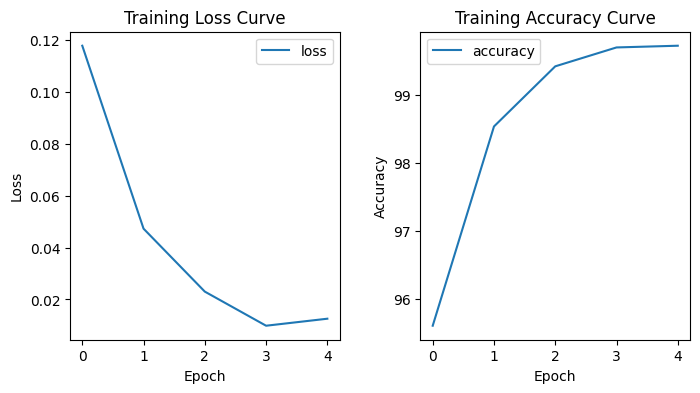

In [23]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the loss curve on the first subplot
ax1.plot(range(len(train_result)), [item[0] for item in train_result], label="loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Curve')
ax1.legend()

# Plot another metric on the second subplot
# Replace the following line with your desired plot
ax2.plot(range(len(train_result)), [item[1] for item in train_result], label="accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Curve')
ax2.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

In [26]:
# test
# ai
!python ../models/radar_finetune_detector.py --model_name "20240528_v2_epoch4.pth" --text "Integrity - the primary consequences of the attack were that records and files were overwritten and government websites were defaced. This compromised the data's integrity by impacting the trustworthiness and accuracy of the information stored on the government systems and websites, with unauthorized and improper alterations made.\n\nAction 1: Ensure all operating systems are kept up to date - this could have potentially thwarted the attack by ensuring that the operating systems were updated with the latest patches that would address known vulnerabilities.\n\nAction 2: Ensure robust security measures are in place for the Master Boot Record (MBR) on all devices - maintaining high levels of security for the MBR would have reduced the likelihood of unauthorized access by enhancing protection on all machines."
# human
!python ../models/radar_finetune_detector.py --model_name "20240528_v2_epoch4.pth" --text "Availability is compromised because the master boot record has been wiped and Files have been overwritten by a wiper.\n\nActions that should have been taken to prevent the attacks includes:\n\nUpdating the OS to have a newer version of Windows because it has better security features and nobody should be able to use an older version of windows because it has more vulnerabilities\n\nAnother action would be having a reliable up-to-date antivirus software to be able to detect the malware and remove it."

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
{'Fake': 0.9990546, 'Real': 0.00094537897}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
{'Fake': 0.006192808, 'Real': 0.99380714}


### Validate

In [90]:
def valid(model, testing_loader):
    model = model.to(device)
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        # for _, data in tqdm(enumerate(testing_loader, 0)):
        for i, data in enumerate(iter(testing_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['target'].to(device, dtype = torch.long)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs.logits, targets)

            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.logits, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if i%100==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_loss, epoch_accu

In [91]:
# model_1 validation
model_1 = torch.load('../models/openai_finetune_models/20240523_v1_epoch0.pth')
val_epoch_loss, val_epoch_acc = valid(model_1, testing_loader)
print(val_epoch_loss, val_epoch_acc)

/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Validation Loss per 100 steps: 0.14860263466835022
Validation Accuracy per 100 steps: 100.0
Validation Loss per 100 steps: 0.08055920187167197
Validation Accuracy per 100 steps: 96.65841584158416
Validation Loss Epoch: 0.08093919815409238
Validation Accuracy Epoch: 96.56912209889
0.08093919815409238 96.56912209889


In [94]:
# model_4 validation

model_4 = torch.load('../models/openai_finetune_models/20240523_v1_epoch4.pth')
val_epoch_loss, val_epoch_acc = valid(model_4, testing_loader)
print(val_epoch_loss, val_epoch_acc)

Validation Loss per 100 steps: 0.4960307776927948
Validation Accuracy per 100 steps: 87.5
Validation Loss per 100 steps: 0.07441227190342897
Validation Accuracy per 100 steps: 98.26732673267327
Validation Loss Epoch: 0.066691413367798
Validation Accuracy Epoch: 98.38546922300706
0.066691413367798 98.38546922300706


In [ ]:
# output_model_file = 'pytorch_roberta_sentiment.bin'
# output_vocab_file = './'

# model_to_save = model
# torch.save(model_to_save, output_model_file)
# tokenizer.save_vocabulary(output_vocab_file)

# print('All files saved')
# print('This tutorial is completed')

In [96]:
model_1 = None
model_4 = None